In [ ]:
import argparse
import os
import struct
import time
from pathlib import Path
from typing import List, Optional, Callable, Sequence, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# For visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tqdm

from torch.cuda.amp import GradScaler, autocast


print("Libraries imported successfully!")

In [ ]:
from python.VQVAE_v2 import *

In [ ]:
BATCH_SIZE = 8192
EPOCHS = 50
LR = 5e-4
IN_CHANNELS = 1
EMBEDDING_DIM = 128  # The dimensionality of the embeddings
NUM_EMBEDDINGS = 256  # The size of the codebook (the "dictionary")
COMMITMENT_COST = 0.25

device = "cuda"
data_dir = "C:/Users/zphrfx/Desktop/hdk/VQVDB/data/vdb_cache/disney/npy"


model = VQVAE(
    in_channels=IN_CHANNELS,
    embedding_dim=EMBEDDING_DIM,
    num_embeddings=NUM_EMBEDDINGS,
    commitment_cost=COMMITMENT_COST,
).to(device)

npy_files = list(Path(data_dir).glob("*.npy"))
if not npy_files:
    raise ValueError(f"No .npy files found in /data/npy")

print(f"Found {len(npy_files)} .npy files")

vdb_dataset = VDBLeafDataset(npy_files=npy_files, include_origins=False, in_channels=IN_CHANNELS)

# Save the model state_dict
model_path = "C:/Users/zphrfx/Desktop/hdk/VQVDB/models/scalar/good_vqvae.pth"

# Visualize the reconstruction quality for a single example
save = torch.load(model_path, map_location=device)
model.load_state_dict(save)
model.eval()


Visualizing Reconstruction Quality for a Single Example


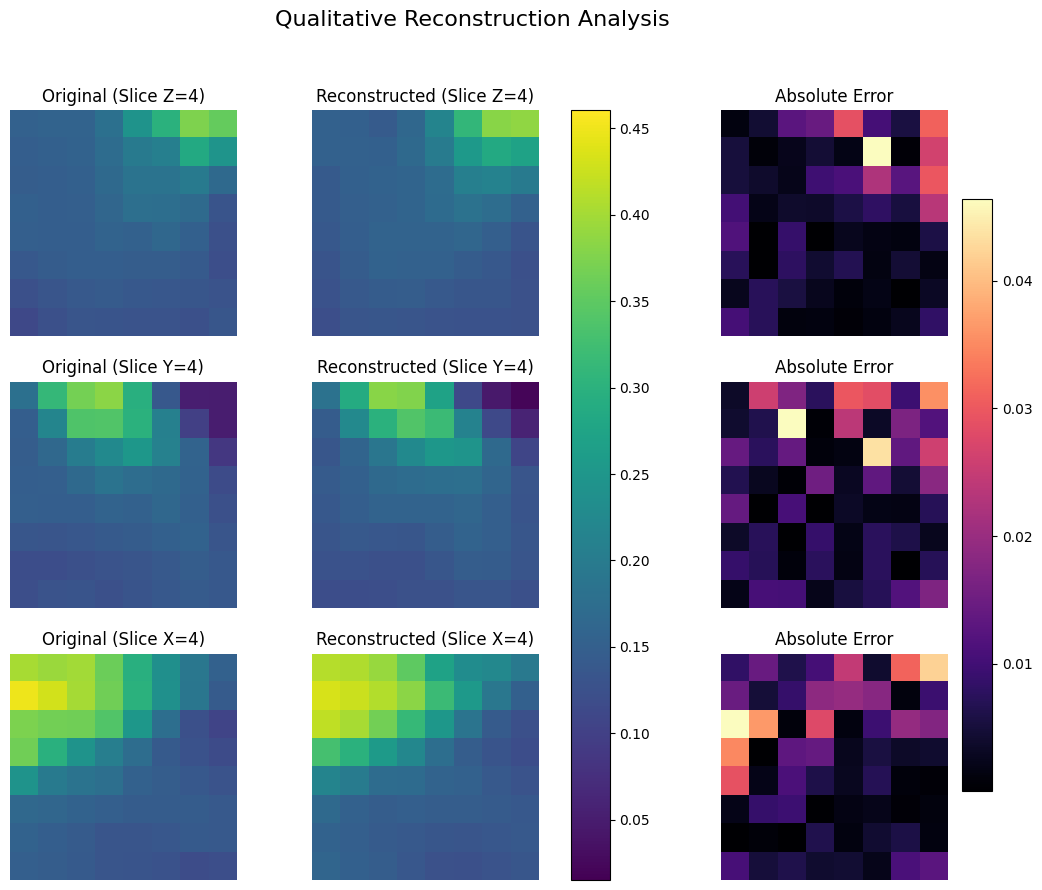

In [17]:
print("Visualizing Reconstruction Quality for a Single Example")

# Get a random block from the dataset
original_block = vdb_dataset[65431].unsqueeze(0).to(device)

# Perform the full compression/decompression cycle
indices = model.encode(original_block)
reconstructed_block = model.decode(indices)

# Detach from GPU and convert to numpy for plotting
original_np = original_block.squeeze().cpu().numpy()
reconstructed_np = reconstructed_block.squeeze().detach().cpu().numpy()
error_np = np.abs(original_np - reconstructed_np)

# Get consistent color limits for fair comparison
vmin = min(original_np.min(), reconstructed_np.min())
vmax = max(original_np.max(), reconstructed_np.max())

# --- Plot 1: Slice-by-Slice Comparison ---
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
center_slice_idx = 4  # Center slice for visualization
im1 = axes[0, 0].imshow(original_np[center_slice_idx, :, :], vmin=vmin, vmax=vmax, cmap='viridis')
axes[0, 0].set_title(f'Original (Slice Z={center_slice_idx})')
axes[0, 0].axis('off')
# Reconstructed (Z=4)
im2 = axes[0, 1].imshow(reconstructed_np[center_slice_idx, :, :], vmin=vmin, vmax=vmax, cmap='viridis')
axes[0, 1].set_title(f'Reconstructed (Slice Z={center_slice_idx})')
axes[0, 1].axis('off')
# Error Map (Z=4)
im3 = axes[0, 2].imshow(error_np[center_slice_idx, :, :], cmap='magma')
axes[0, 2].set_title('Absolute Error')
axes[0, 2].axis('off')

# --- Row 2: Y-Axis Slice ---
# Original (Y=4)
axes[1, 0].imshow(original_np[:, center_slice_idx, :], vmin=vmin, vmax=vmax, cmap='viridis')
axes[1, 0].set_title(f'Original (Slice Y={center_slice_idx})')
axes[1, 0].axis('off')
# Reconstructed (Y=4)
axes[1, 1].imshow(reconstructed_np[:, center_slice_idx, :], vmin=vmin, vmax=vmax, cmap='viridis')
axes[1, 1].set_title(f'Reconstructed (Slice Y={center_slice_idx})')
axes[1, 1].axis('off')
# Error Map (Y=4)
axes[1, 2].imshow(error_np[:, center_slice_idx, :], cmap='magma')
axes[1, 2].set_title('Absolute Error')
axes[1, 2].axis('off')

# --- Row 3: X-Axis Slice ---
# Original (X=4)
axes[2, 0].imshow(original_np[:, :, center_slice_idx], vmin=vmin, vmax=vmax, cmap='viridis')
axes[2, 0].set_title(f'Original (Slice X={center_slice_idx})')
axes[2, 0].axis('off')
# Reconstructed (X=4)
axes[2, 1].imshow(reconstructed_np[:, :, center_slice_idx], vmin=vmin, vmax=vmax, cmap='viridis')
axes[2, 1].set_title(f'Reconstructed (Slice X={center_slice_idx})')
axes[2, 1].axis('off')
# Error Map (X=4)
axes[2, 2].imshow(error_np[:, :, center_slice_idx], cmap='magma')
axes[2, 2].set_title('Absolute Error')
axes[2, 2].axis('off')

fig.colorbar(im1, ax=axes[:,:2], orientation='vertical', fraction=.1)
fig.colorbar(im3, ax=axes[:,2], orientation='vertical', fraction=.1)
plt.suptitle('Qualitative Reconstruction Analysis', fontsize=16)
plt.show()

In [ ]:

# plot losses and perplexity
rl = save['recon_loss_l']
vq_loss_l = save['vq_loss_l']
perplexity_l = save['perplexity_l']

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(rl, label='Reconstruction Loss', color='blue')
plt.plot(vq_loss_l, label='VQ Loss', color='orange')
plt.title('Training Losses')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(perplexity_l, label='Perplexity', color='green')
plt.title('Perplexity Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Perplexity')
plt.legend()
plt.tight_layout()
plt.show()


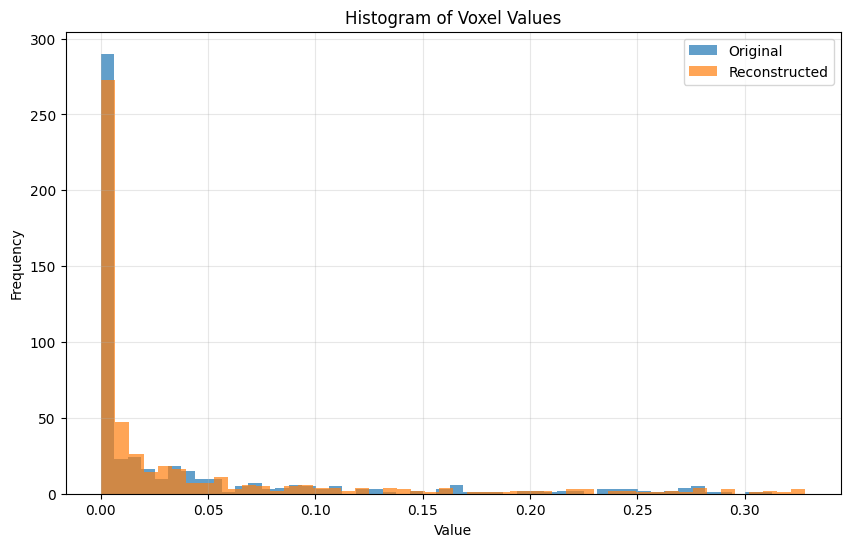

KL Divergence between original and reconstructed blocks: 0.1354


In [8]:
plt.figure(figsize=(10, 6))
plt.hist(original_np.flatten(), bins=50, alpha=0.7, label='Original')
plt.hist(reconstructed_np.flatten(), bins=50, alpha=0.7, label='Reconstructed')
plt.title('Histogram of Voxel Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

from scipy.stats import entropy
def kl_divergence(p, q):
    """Compute KL divergence between two distributions."""
    p = p.flatten()
    q = q.flatten()
    p = p / np.sum(p)  # Normalize
    q = q / np.sum(q)  # Normalize
    return entropy(p, q)
kl_div = kl_divergence(original_np, reconstructed_np)
print(f"KL Divergence between original and reconstructed blocks: {kl_div:.4f}")

PCA of the learned codebook vectors:


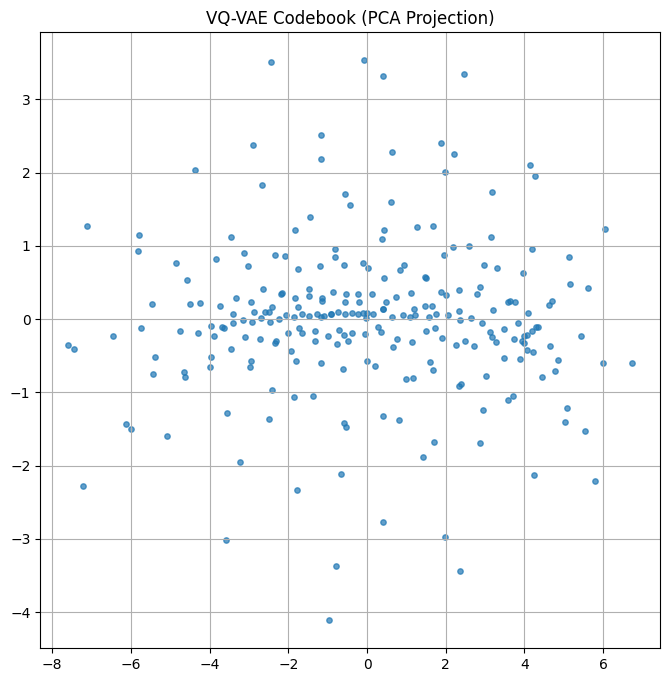


Calculating codebook usage across the entire dataset...


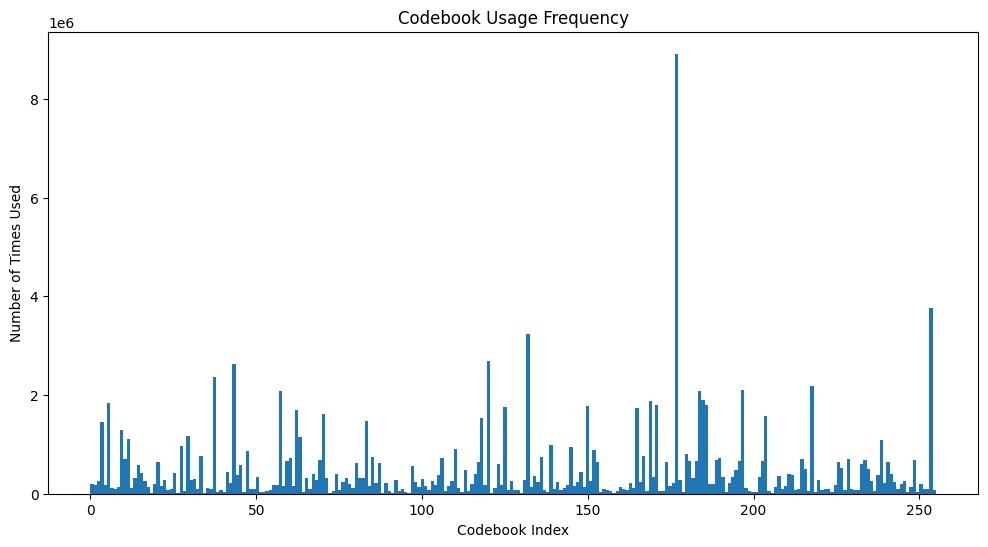

Number of 'dead' (unused) codes: 0 out of 256


In [9]:
print("PCA of the learned codebook vectors:")
codebook = model.quantizer.embedding.data.cpu()
pca = PCA(n_components=2)
codebook_2d = pca.fit_transform(codebook)
plt.figure(figsize=(8, 8))
plt.scatter(codebook_2d[:, 0], codebook_2d[:, 1], s=15, alpha=0.7)
plt.title('VQ-VAE Codebook (PCA Projection)')
plt.grid(True)
plt.show()

# --- Plot 2: Codebook Usage Histogram ---
# This is a powerful diagnostic. It requires running the encoder on the whole dataset.
print("\nCalculating codebook usage across the entire dataset...")
model.eval()
all_indices = []
# Create a dataloader without shuffling to iterate through the dataset
full_loader = DataLoader(vdb_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for data_batch in full_loader:
        data_batch = data_batch.to(device) # Move data to the same device as the model
        indices = model.encode(data_batch)
        all_indices.append(indices.cpu().numpy().flatten())

all_indices = np.concatenate(all_indices)

plt.figure(figsize=(12, 6))
plt.hist(all_indices, bins=NUM_EMBEDDINGS, range=(0, NUM_EMBEDDINGS-1))
plt.title('Codebook Usage Frequency')
plt.xlabel('Codebook Index')
plt.ylabel('Number of Times Used')
plt.show()

num_dead_codes = NUM_EMBEDDINGS - len(np.unique(all_indices))
print(f"Number of 'dead' (unused) codes: {num_dead_codes} out of {NUM_EMBEDDINGS}")

In [10]:
# --- Codebook Perplexity + Active-Code Ratio ---
counts = np.bincount(all_indices, minlength=NUM_EMBEDDINGS).astype(np.float64)
probs = counts / counts.sum()
nonzero = probs > 0
perplexity = np.exp(-(probs[nonzero] * np.log(probs[nonzero])).sum())
active_ratio = nonzero.mean()

print(f"Codebook perplexity: {perplexity:.2f}")
print(f"Active-code ratio  : {active_ratio*100:.1f}%")


Codebook perplexity: 122.63
Active-code ratio  : 100.0%


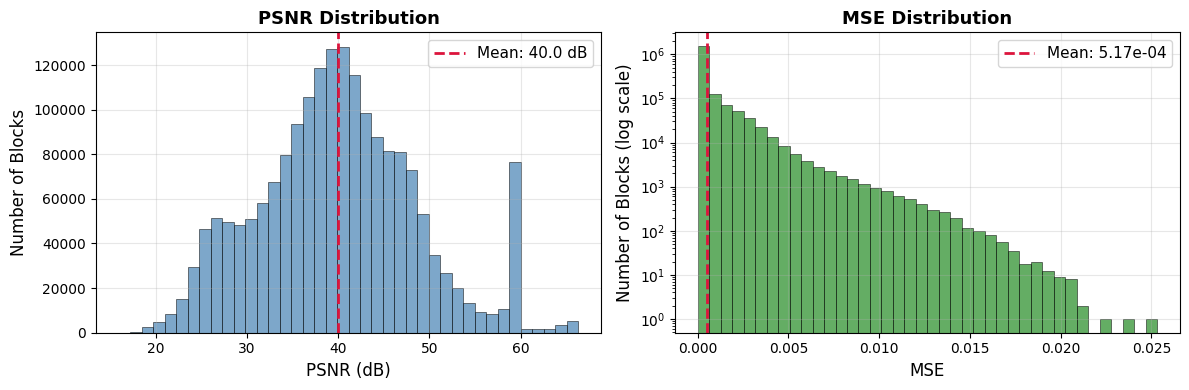

Reconstruction Quality Metrics:
Average PSNR: 39.96 dB
Average MSE: 5.17e-04
PSNR std: 8.75 dB
MSE std: 1.16e-03


In [14]:
from math import log10

def psnr(x, y, vmax=1.0):
    mse = torch.mean((x - y) ** 2).item()
    return 20 * log10(vmax) - 10 * log10(mse + 1e-12)

model.eval()
psnr_list, mse_list = [], []

with torch.no_grad():
    for batch in DataLoader(vdb_dataset, batch_size=BATCH_SIZE, shuffle=False):
        batch = batch.to(device)
        rec = model.decode(model.encode(batch))
        mse = ((batch - rec) ** 2).view(len(batch), -1).mean(dim=1)
        mse_list.extend(mse.cpu().numpy())
        psnr_list.extend([psnr(b, r) for b, r in zip(batch, rec)])

avg_psnr = np.mean(psnr_list)
avg_mse = np.mean(mse_list)

# Create publication-ready plots
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# PSNR Distribution
ax1.hist(psnr_list, bins=40, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax1.axvline(avg_psnr, color='crimson', linestyle='--', linewidth=2, 
           label=f'Mean: {avg_psnr:.1f} dB')
ax1.set_xlabel('PSNR (dB)', fontsize=12)
ax1.set_ylabel('Number of Blocks', fontsize=12)
ax1.set_title('PSNR Distribution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=10)

# MSE Distribution
ax2.hist(mse_list, bins=40, alpha=0.7, color='forestgreen', edgecolor='black', linewidth=0.5)
ax2.axvline(avg_mse, color='crimson', linestyle='--', linewidth=2,
           label=f'Mean: {avg_mse:.2e}')
ax2.set_xlabel('MSE', fontsize=12)
ax2.set_ylabel('Number of Blocks (log scale)', fontsize=12)
ax2.set_title('MSE Distribution', fontsize=13, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

print(f"Reconstruction Quality Metrics:")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average MSE: {avg_mse:.2e}")
print(f"PSNR std: {np.std(psnr_list):.2f} dB")
print(f"MSE std: {np.std(mse_list):.2e}")


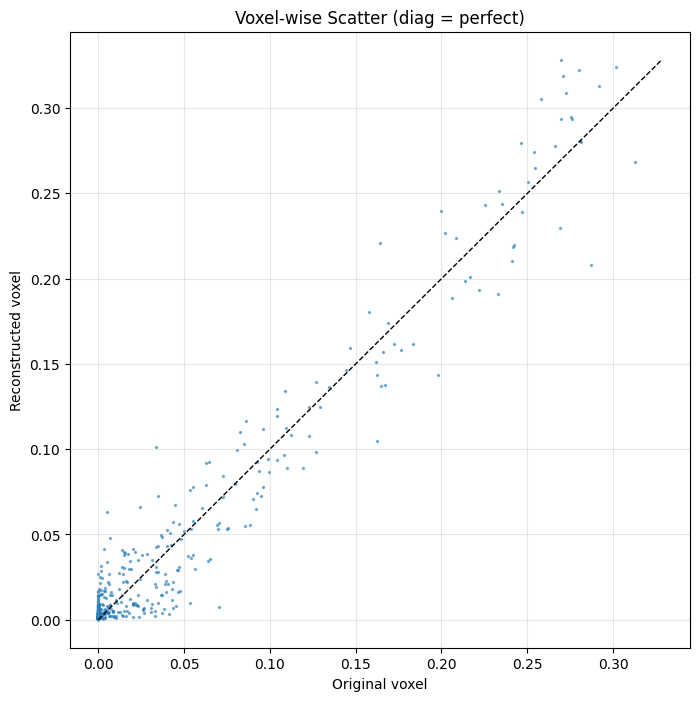

In [11]:
n_points = 100000
orig_sample = original_np.flatten()
recon_sample = reconstructed_np.flatten()
if len(orig_sample) > n_points:
    idx = np.random.choice(len(orig_sample), n_points, replace=False)
    orig_sample = orig_sample[idx]; recon_sample = recon_sample[idx]

plt.figure(figsize=(8,8))
plt.scatter(orig_sample, recon_sample, s=2, alpha=.5)
lims = [min(orig_sample.min(), recon_sample.min()),
        max(orig_sample.max(), recon_sample.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel('Original voxel'); plt.ylabel('Reconstructed voxel')
plt.title('Voxel-wise Scatter (diag = perfect)')
plt.grid(True, alpha=.3); plt.show()


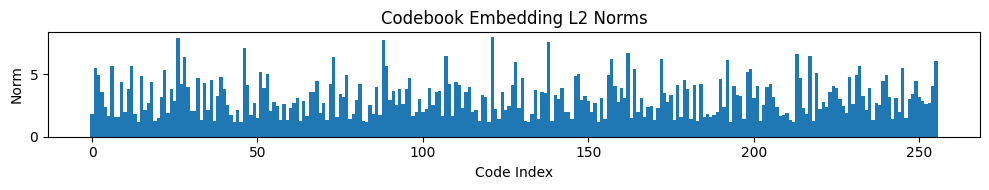

In [12]:
# --- L2 norm of each embedding vector ---
embed_norm = torch.linalg.norm(model.quantizer.embedding.data, dim=1).cpu().numpy()
plt.figure(figsize=(10,2))
plt.bar(range(NUM_EMBEDDINGS), embed_norm, width=1.0)
plt.title('Codebook Embedding L2 Norms'); plt.xlabel('Code Index'); plt.ylabel('Norm')
plt.tight_layout(); plt.show()


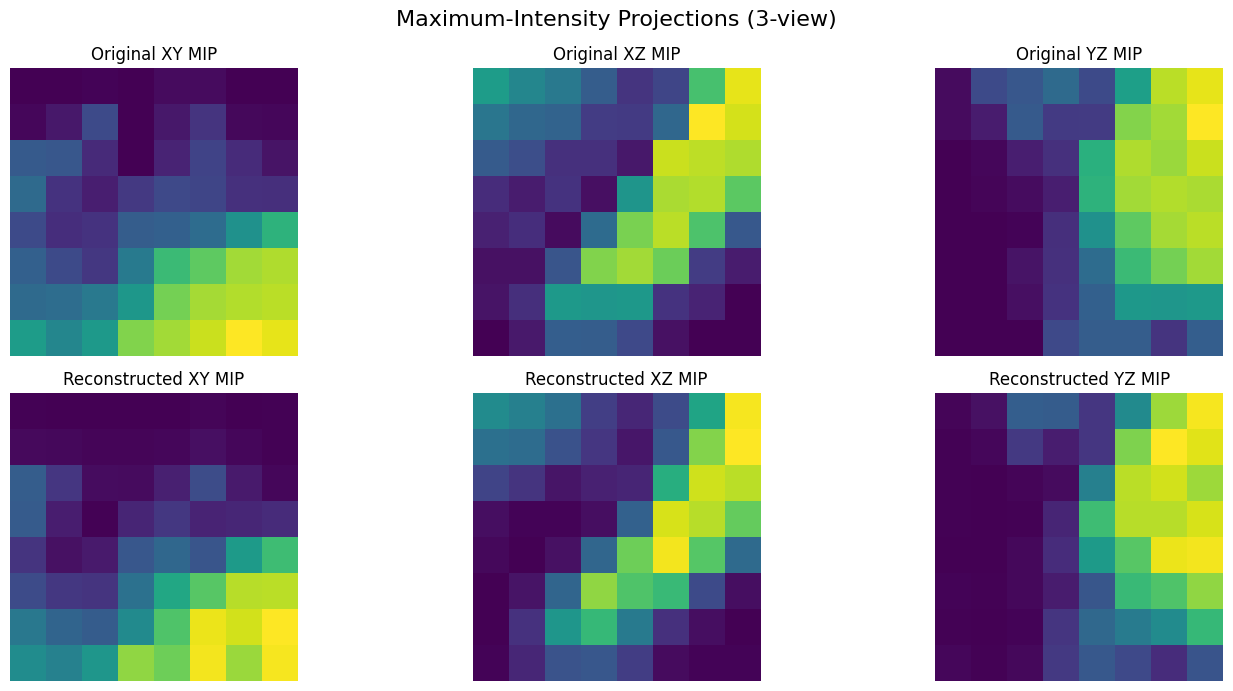

In [13]:
def mip(vol, axis):
    """Maximum-intensity projection along a single axis."""
    return vol.max(axis=axis)

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
views = [(0, 'XY MIP'),   # collapse Z
         (1, 'XZ MIP'),   # collapse Y
         (2, 'YZ MIP')]   # collapse X

for col, (axis_to_collapse, title) in enumerate(views):
    axes[0, col].imshow(mip(original_np, axis=axis_to_collapse), cmap='viridis')
    axes[0, col].set_title(f'Original {title}')
    axes[0, col].axis('off')

    axes[1, col].imshow(mip(reconstructed_np, axis=axis_to_collapse), cmap='viridis')
    axes[1, col].set_title(f'Reconstructed {title}')
    axes[1, col].axis('off')

plt.suptitle('Maximum-Intensity Projections (3-view)', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# ---------- 1. Build a per-block latent vector ----------
model.eval()
latents, errs = [], []          # errs = optional colouring

with torch.no_grad():
    for batch in DataLoader(vdb_dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=False):
        batch = batch.to(device)
        
        idx = model.encode(batch).long()               # (B, Z, Y, X) indices
        emb = model.quantizer.embedding[idx.view(-1)]  # (B*Z*Y*X, C)
        emb = emb.view(*idx.shape, -1)                 # (B, Z, Y, X, C)
        mean_emb = emb.mean(dim=(1, 2, 3))             # (B, C)
        latents.append(mean_emb.cpu())
        
        # Optional: per-block MSE for coloured scatter
        rec = model.decode(idx)
        errs.append(((batch - rec) ** 2)
                    .view(len(batch), -1)
                    .mean(dim=1)
                    .cpu())

latents = torch.cat(latents, dim=0).numpy()   # (N, C)
errs    = torch.cat(errs, dim=0).numpy()      # (N,)

# ---------- 2. PCA to 2-D ----------
from sklearn.decomposition import FastICA
pca2 = FastICA(n_components=2, random_state=0)
latents_2d = pca2.fit_transform(latents)      # (N, 2)

# ---------- 3. Scatter with viridis ----------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sc = plt.scatter(latents_2d[:, 0],
                 latents_2d[:, 1],
                 c=errs,                 # <- set to None for uniform colour
                 cmap='viridis',
                 s=4,
                 alpha=0.8)
if sc.get_array() is not None:           # only if colouring by a value
    plt.colorbar(sc, label='Block MSE')

plt.title('Latent Space Sampling (PCA-2D, viridis)')
plt.xlabel('PC-1'); plt.ylabel('PC-2')
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()


Processing 8192 batches for analysis...


100%|██████████| 58/58 [00:21<00:00,  2.74it/s]


Analysis will be performed on 242017280 individual float values.
Calculating binned quantities...
Generating 2D histograms...


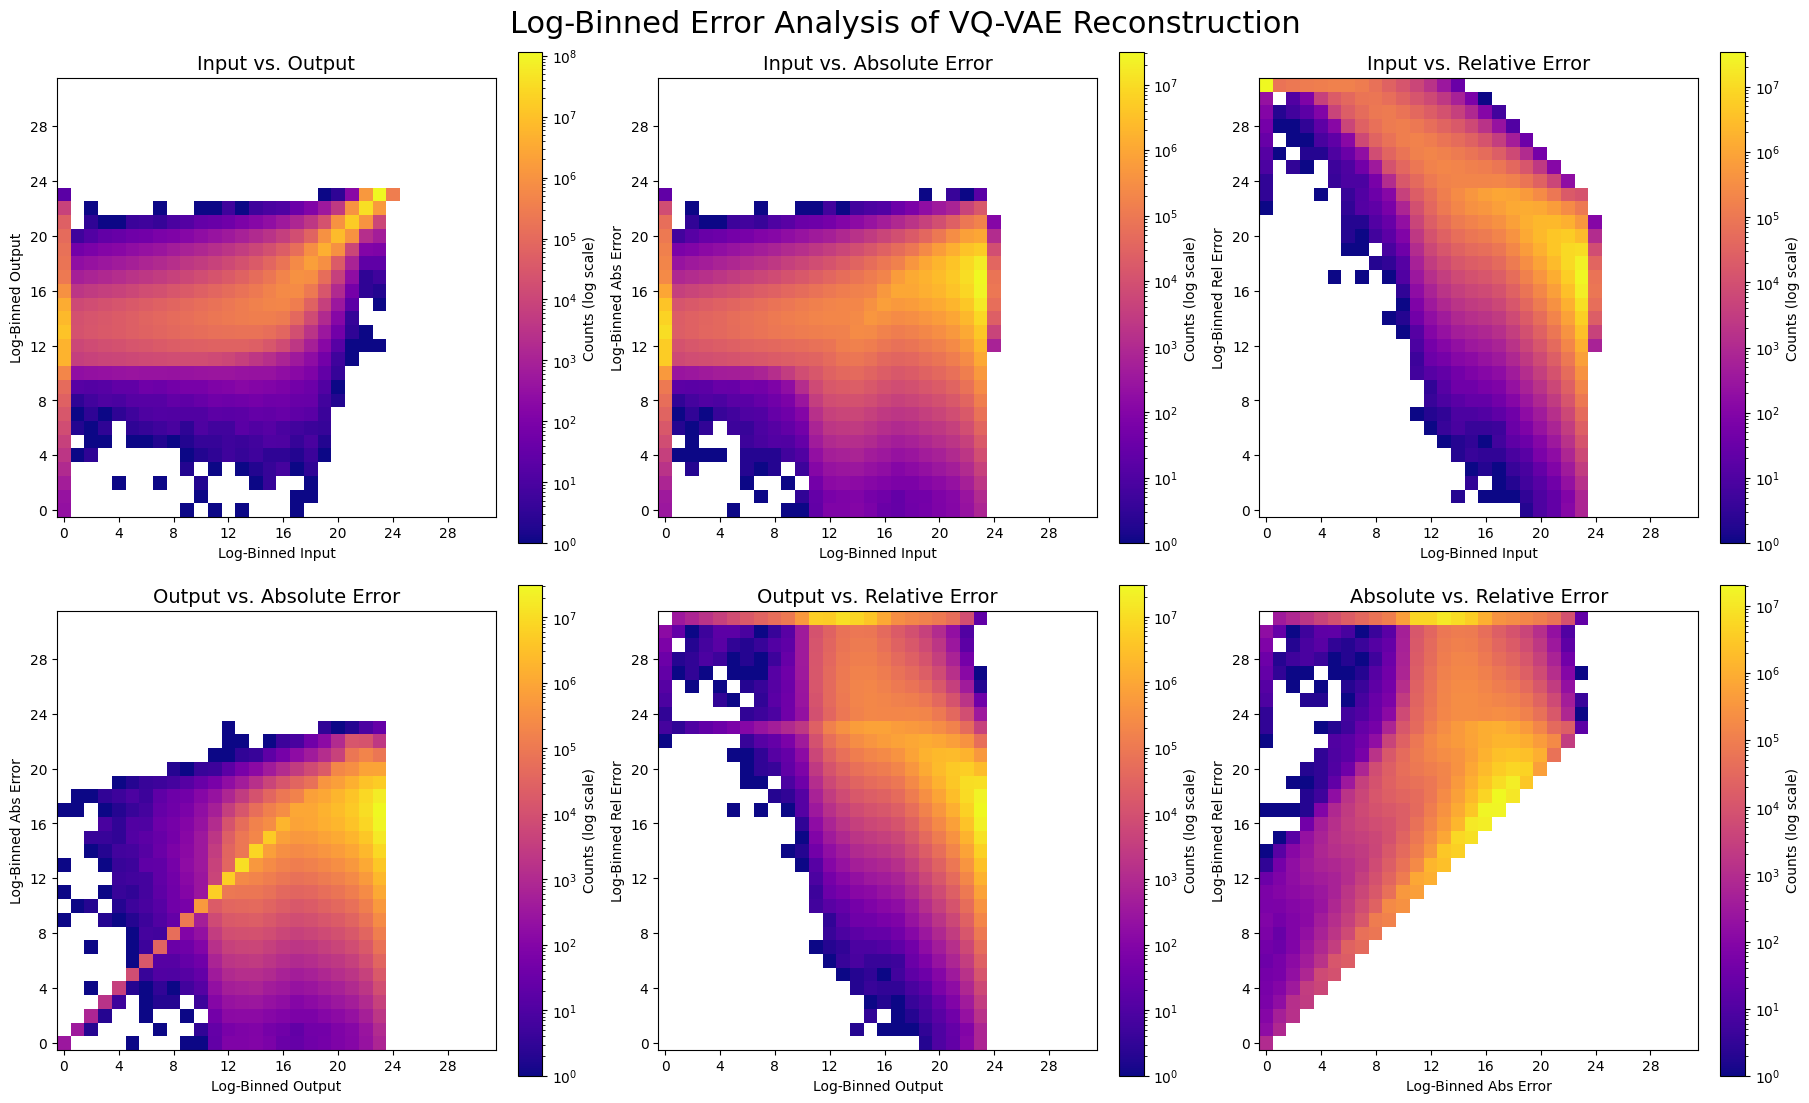

In [23]:
all_original_np = []
all_reconstructed_np = []

import tqdm
from matplotlib.colors import LogNorm



split_idx = len(vdb_dataset) // 2
vdb_dataset_val = torch.utils.data.Subset(vdb_dataset, range(split_idx//2))

print(f"Processing {BATCH_SIZE} batches for analysis...")
with torch.no_grad():
    for i, batch in enumerate(tqdm.tqdm(DataLoader(vdb_dataset_val, batch_size=BATCH_SIZE, shuffle=False))):
        if i >= BATCH_SIZE:
            break
        
        original_block = batch.to(device)
        indices = model.encode(original_block)
        reconstructed_block = model.decode(indices)
        
        # Permute to (B, D, H, W, C) for easier component-wise processing
        all_original_np.append(original_block.permute(0, 2, 3, 4, 1).cpu().numpy())
        all_reconstructed_np.append(reconstructed_block.permute(0, 2, 3, 4, 1).cpu().numpy())

# Concatenate all batches into large numpy arrays
original_np = np.concatenate(all_original_np)
reconstructed_np = np.concatenate(all_reconstructed_np)

print(f"Analysis will be performed on {original_np.size} individual float values.")

# --- 4. Define the Log-Binning Function and Calculate Quantities ---

def log_bin_value(v_np):
    """
    Computes int(clamp(log2(abs(v)) + 24, 0, 31)) for a numpy array.
    A small epsilon is added to handle log2(0).
    """
    # Epsilon to avoid log2(0) -> -inf
    epsilon = 1e-30
    log2_val = np.log2(np.abs(v_np) + epsilon)
    binned = np.clip(log2_val + 24, 0, 31)
    return binned.astype(np.int32)

print("Calculating binned quantities...")
# Calculate the four primary quantities
v_in_binned = log_bin_value(original_np)
v_out_binned = log_bin_value(reconstructed_np)

# Calculate errors before binning
abs_error_np = np.abs(original_np - reconstructed_np)
# Add epsilon to denominator to avoid division by zero
rel_error_np = abs_error_np / (np.abs(original_np) + 1e-9)

abs_err_binned = log_bin_value(abs_error_np)
rel_err_binned = log_bin_value(rel_error_np)

# --- 5. Create the 2D Histograms ---
print("Generating 2D histograms...")

# Define the 6 plots we want to create
plots_to_make = [
    {'x': v_in_binned, 'y': v_out_binned, 'title': 'Input vs. Output', 'xlabel': 'Log-Binned Input', 'ylabel': 'Log-Binned Output'},
    {'x': v_in_binned, 'y': abs_err_binned, 'title': 'Input vs. Absolute Error', 'xlabel': 'Log-Binned Input', 'ylabel': 'Log-Binned Abs Error'},
    {'x': v_in_binned, 'y': rel_err_binned, 'title': 'Input vs. Relative Error', 'xlabel': 'Log-Binned Input', 'ylabel': 'Log-Binned Rel Error'},
    {'x': v_out_binned, 'y': abs_err_binned, 'title': 'Output vs. Absolute Error', 'xlabel': 'Log-Binned Output', 'ylabel': 'Log-Binned Abs Error'},
    {'x': v_out_binned, 'y': rel_err_binned, 'title': 'Output vs. Relative Error', 'xlabel': 'Log-Binned Output', 'ylabel': 'Log-Binned Rel Error'},
    {'x': abs_err_binned, 'y': rel_err_binned, 'title': 'Absolute vs. Relative Error', 'xlabel': 'Log-Binned Abs Error', 'ylabel': 'Log-Binned Rel Error'}
]

fig, axes = plt.subplots(2, 3, figsize=(18, 11), constrained_layout=True)
axes = axes.flatten()

# Bins for a 32x32 histogram (from 0 to 31)
bins = np.arange(33) - 0.5

for i, plot_info in enumerate(plots_to_make):
    ax = axes[i]
    
    # Flatten the arrays to create the 1D list of values for the histogram
    x_data = plot_info['x'].flatten()
    y_data = plot_info['y'].flatten()
    
    # Create the 2D histogram
    hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=bins)
    
    # Use LogNorm for the color scale to see low-count bins. vmin=1 avoids log(0)
    # Transpose hist (H.T) because imshow's axes are swapped compared to histogram2d's
    im = ax.imshow(hist.T, origin='lower', cmap='plasma', norm=LogNorm(vmin=1))
    
    ax.set_title(plot_info['title'], fontsize=14)
    ax.set_xlabel(plot_info['xlabel'], fontsize=10)
    ax.set_ylabel(plot_info['ylabel'], fontsize=10)
    
    # Set ticks to be the bin centers
    tick_locs = np.arange(0, 32, 4)
    ax.set_xticks(tick_locs)
    ax.set_yticks(tick_locs)
    
    fig.colorbar(im, ax=ax, label="Counts (log scale)")

fig.suptitle("Log-Binned Error Analysis of VQ-VAE Reconstruction", fontsize=22)
plt.show()